# Parameter Fitting for Mortals

In [1]:
# Python packages used in this chapter
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te
from SBstoat.namedTimeseries import NamedTimeseries, TIME
from SBstoat.modelFitter import ModelFitter

In [2]:
# Constants used in this chapter
EXAMPLE_DATA_PATH = "../common/models/fitting_example.csv"

Parameters are constants used in models, such as kinetics contants for reactions.
Although there is often knowledge of likely ranges of parameter values, the appropriate value is often unknown
for a specific model.

To make these ideas concrete, consider a linear pathway consisting of three species ``S1``, ``S2``, and ``S3``. That is, ``S1`` $\rightarrow$ ``S2`` $\rightarrow$ ``S3``.
The Antimony model is shown below.

In [3]:
PATHWAY_MODEL = '''
R1:  S1 -> S2; k1*S1  
R2a: S2 -> S3; k2*S2

S1 = 10

// Parameters
k1 = 0; # Nominal value of parameter
k2 = 0; # Nominal value of parameter
'''

Note that the values of the parameters are 0! This is not because their true value is 0.
Rather, it's because we don't know the value of these parameters.

It is very common to have parameters with unknown values in kinetics models. Typically, we know the range
of the parameter values, but not a suitable value itself.

So, how do we run a model with known values for *all* of its parameters? The answer is that we estimate or **fit paramter values** based on observed data.

For this example, the observational data are in the file specified in ``EXAMPLE_DATA_PATH``.

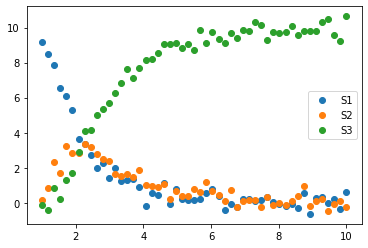

In [4]:
data = NamedTimeseries(csvPath=EXAMPLE_DATA_PATH)
fig, ax = plt.subplots(1)
for col in data.colnames:
    ax.scatter(data[TIME], data[col])
_ = plt.legend(data.colnames)

The following sections provide details of parameter fitting using the ``PATHWAY_MODEL``.

## Fitting Basics

Some key concepts are:
- A **parameter** is a constant whose value is unknown.
- **Observed data** are data that are used for fitting parameter values.
- **Fitted data** are data produced by a simulation for an assignment of values to parameters.
- **Residuals** are the difference between observed data and simulated data.

The basic algorithm for fitting is described below.
The algorithm estimates ``parameters``, the vector of values of unknown parameters.
The inputs to the algoritm are:
- ``model`` - the simulation model
- ``parameters`` parameters to estimate with their initial values
- ``observedData`` observed data used for fitting

1. **Initialization**
   1. ``fittedData = simulate(model, parameters)``
   1. ``residuals = observedData - fittedData``
1. **Loop**
   1. ``parameters`` = adjust ``parameters`` based on ``residuals``
   1. ``fittedData = simulation(parameters)``
   1. ``residuals = observedData - fittedData``
   1. if ``residuals`` are small
       1. ``return parameters``

The algorithm is fairly straight forward, with one exception.
Step A - "adjust ``parameters`` based on ``residuals``" How are these adjustments made?

The adjustments are made based on an optimization that chooses parameter values that
minimize the residuals.
We give a brief discussion of optimization in the next section.

## Optimization Essentials

Given a function $f(x_1, \cdots, x_n)$, an optimizer finds $(x_1^{\star}, \cdots, x_n^{\star})$
that results in the smallest value of $f(x_1, \cdots, x_n)$.

Sometimes, this search is easy. Consider the curve below.

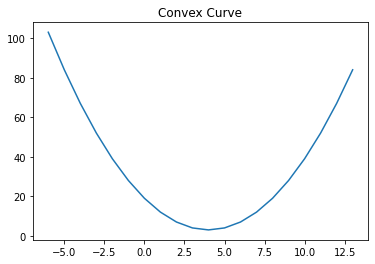

In [5]:
xv = np.array(range(20))
xv = xv - 6
_ = plt.plot(xv, 3 + (xv - 4)**2 )
_ = plt.title("Convex Curve")

We can readily see that the minimum value of this function occurs at $x^{\star} = 4$.
This is an example of a convex curve. A convex curve has the very nice property
that its local minimum is also the global minimum.
That is, there are no small valleys where the optimizer might get "stuck".
For this reason, it's easy to find $x^{\star}$ using gradient decent or
Newton's method.

Unfortunately, convex curves are rare in practice. Much more common is something like the following.

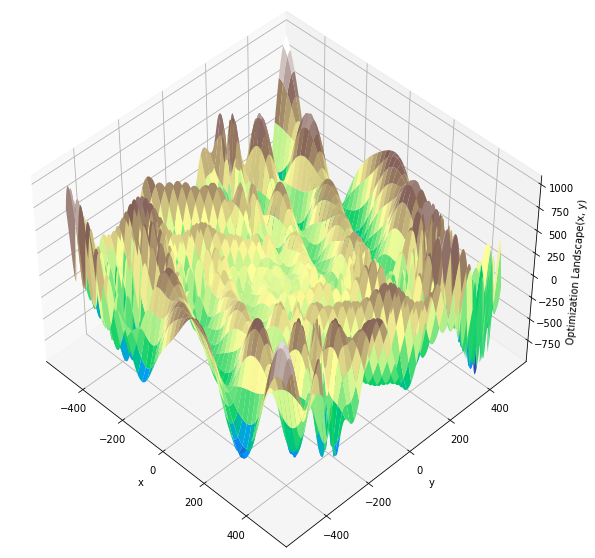

In [6]:
from mpl_toolkits.mplot3d import Axes3D

def eggholder(x):
    return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))
          -x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))

x = np.arange(-512, 513)
y = np.arange(-512, 513)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Optimization Landscape(x, y)')
plt.show()

For curves such as these, hueristic methods are needed such as differential evolution, simulated annealing, and random stochastic
gradient descent.

## Fitting With SBstoat

### Running Example

### Doing the fit

### Evaluating Quality of Fit

## Fitting for Glycolytic Oscillations

## Estimating Parameter Variances With Bootstrapping

## Tips for Fitting

There is considerable art in fitting. The quality of parameter fits
can be improved by exploring the following:
- **What you fit**. This means, which species concentrations you include in the residuals, what part of the time course
you try to fit, and the ranges you choose for parameter values.
- **How you fit**. There are several different algorithms for doing non-linear minimizations...
- **How much compute**. Fitting is computationally intensive. More compute time is often needed for a better result. ``SBstoat`` helps
in this regard by making use of multiple cores.

## Appendix 1 - Synthetic Observational Data for Linear Pathway
This appendix describes how data was generated to create synthetic observations for the linear pathway example.

The first step is to generate data for the "ground truth" model.

In [7]:
# Ground truth values of parameters
GROUNDTRUTH_k1 = 0.8
GROUNDTRUTH_k2 = 1.2

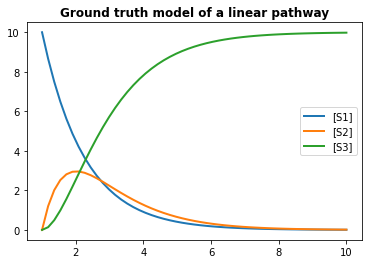

In [8]:
rr = te.loada(PATHWAY_MODEL)
rr.k1 = GROUNDTRUTH_k1
rr.k2 = GROUNDTRUTH_k2
data = rr.simulate(1, 10)
rr.plot(data, title="Ground truth model of a linear pathway")

Next, we convert the output data, a numpy named array, into a ``NamedTimeseries``, a data structure that is well suited for
time series manipulations.

In [9]:
timeseriesData = NamedTimeseries(namedArray=data)

Now, we add some random noise. For this example, we add normally distributed random variables with a mean of 0
and a standard deviation of 0.2.

In [10]:
timeseriesData[timeseriesData.colnames] += np.random.normal(0, 0.3, (len(timeseriesData), 3))

Last, we write the result to a file.

In [11]:
#timeseriesData.to_csv(EXAMPLE_DATA_PATH)

## Appendix 2 - Synthetic Observational Data for Glycolytic Oscilations
This appendix describes how data was generated to create synthetic observations for the Wolf
glycolytic oscillations model.

As in Appendix 1, we start with a ground truth model.

In [12]:
# Constants used in this Appendix
WOLF_MODEL = "../common/models/Jana_WolfGlycolysis.antimony"
ENDTIME = 5
NUMPOINT = 100*ENDTIME
STD = 0.3

In [13]:
rr = te.loada(WOLF_MODEL)
data = rr.simulate(0, ENDTIME, NUMPOINT)
origTS = NamedTimeseries(namedArray=data)
synTS = origTS.copy()
synTS[origTS.colnames] += np.random.normal(0, STD, (len(origTS), len(origTS.colnames)))

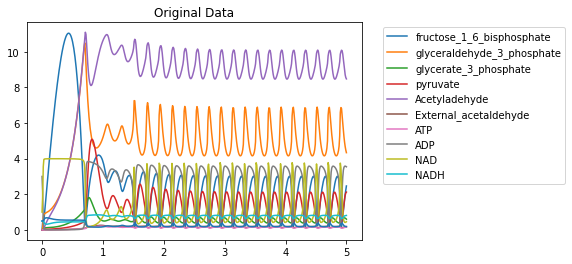

In [14]:
p = plt.plot(origTS[TIME], origTS[origTS.colnames])
_ = plt.legend(p, origTS.colnames[1:], bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title("Original Data")

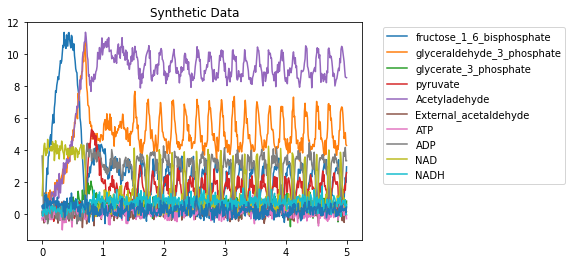

In [15]:
p = plt.plot(synTS[TIME], synTS[synTS.colnames])
_ = plt.legend(p, synTS.colnames[1:], bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title("Synthetic Data")